In [14]:
from general_utils import *
from own_utils import *

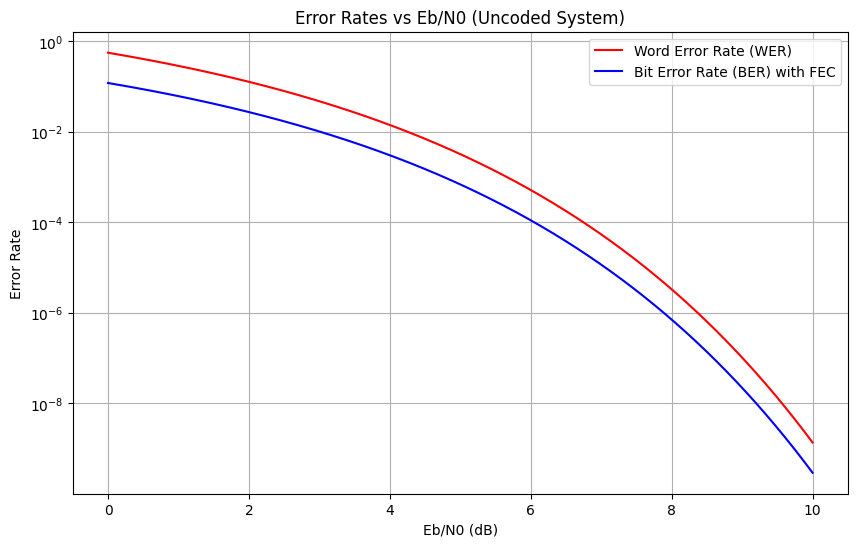

In [15]:
# Proposed code analysis

# Generate Eb/N0 values for simulation, create two ranges with different granularity and concatenate them
EbN0_dB_low = np.linspace(0, 4, 100)  # Less granular for 0-4 dB
EbN0_dB_high = np.linspace(4, 10, 1000)  # More granular for 4-10 dB
EbN0_dB = np.concatenate([EbN0_dB_low, EbN0_dB_high[1:]])  # Combine ranges, avoiding duplicate at 4
EbN0 = 10**(EbN0_dB/10)  # Convert to linear scale

# Calculate bit error probability using Q-function
Peb = 0.5 * erfc(np.sqrt(EbN0))  # Q(sqrt(2Eb/N0)) = 0.5*erfc(sqrt(Eb/N0))

# Calculate word error probability (assuming independent bit errors and assuming p << 1)
Pew = comb(n, tc+1) * Peb**(tc+1)  # Word error probability using binomial coefficient
Pebf = ((2*tc +1)/ n) * comb(n, tc +1) *Peb **(tc +1)

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_dB, Pew, 'r-', label='Word Error Rate (WER)')
plt.semilogy(EbN0_dB, Pebf, 'b-', label='Bit Error Rate (BER) with FEC')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 (Uncoded System)')
plt.legend()
plt.show()


In [7]:
# Considering corrector code

# Simulate error rates for coded and uncoded system, with error correction
num_trials = 100  # Number of trials for each Eb/N0 value
source_ber = []  # Source bit error rate
source_wer = []  # Source word error rate
uncoded_ber = []  # Uncoded bit error rate

for eb_n0 in EbN0:
    ber_trials = []  # Store BER for each trial
    wer_trials = []  # Store WER for each trial
    uncoded_ber_trials = []  # Store uncoded BER for each trial
    
    for _ in range(num_trials):
        source_message = np.random.randint(0, 2, k)
        
        # Calculate uncoded BER
        uncoded_received = noisy_channel(source_message, n=k, k=k, EbfN0=eb_n0)
        uncoded_bit_errors = np.sum(source_message != uncoded_received)
        uncoded_ber_trials.append(uncoded_bit_errors / k)
        
        # Coded system simulation
        encoded_message = encode_message(source_message, G)
        received_codeword = noisy_channel(encoded_message, n=n, k=k, EbfN0=eb_n0)
        decoded_message = decode_message(received_codeword, H, n)

        # Calculate bit errors
        bit_errors = np.sum(source_message != decoded_message[0, :k])
        ber_trials.append(bit_errors / k)

        # Calculate word errors
        word_errors = 1 if np.any(encoded_message != received_codeword) else 0
        wer_trials.append(word_errors)
    
    # Average the results over all trials
    source_ber.append(np.mean(ber_trials))
    source_wer.append(np.mean(wer_trials))
    uncoded_ber.append(np.mean(uncoded_ber_trials))

# Convert to numpy arrays and calculate average error rates
source_ber = np.array(source_ber)
source_wer = np.array(source_wer)
uncoded_ber = np.array(uncoded_ber)

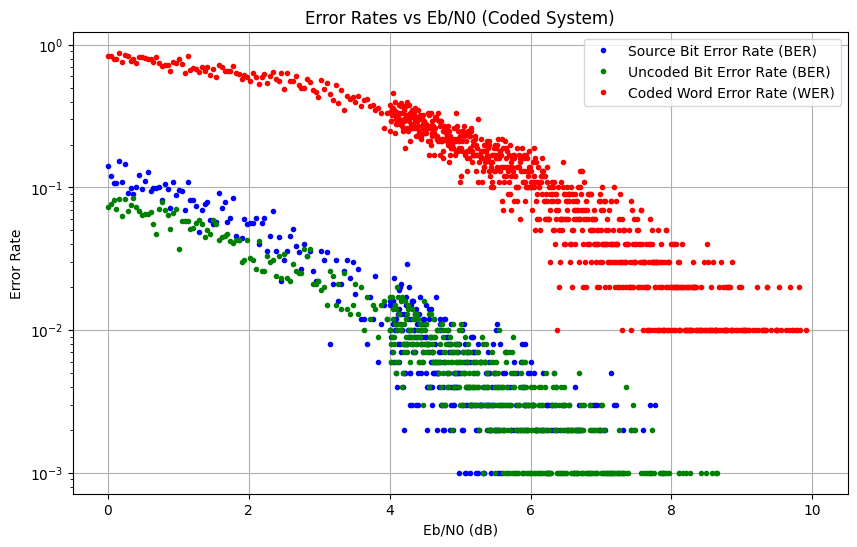

In [8]:
# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_dB, source_ber, 'b.', label='Source Bit Error Rate (BER)')
plt.semilogy(EbN0_dB, uncoded_ber, 'g.', label='Uncoded Bit Error Rate (BER)')
plt.semilogy(EbN0_dB, source_wer, 'r.', label='Coded Word Error Rate (WER)')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 (Coded System)')
plt.legend()
plt.show()

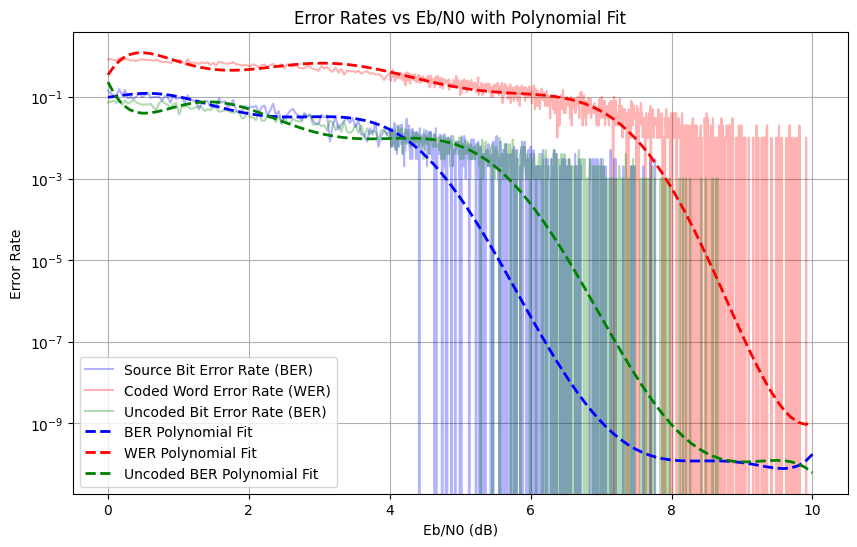

In [9]:
# Fit polynomial using least squares method
from numpy.polynomial import Polynomial

# Fit polynomials to log10 of error rates, handling zero values
# Add small epsilon to avoid log10(0)
epsilon = 1e-10
ber_poly = Polynomial.fit(EbN0_dB, np.log10(source_ber + epsilon), deg=8)
wer_poly = Polynomial.fit(EbN0_dB, np.log10(source_wer + epsilon), deg=8)
uncoded_ber_poly = Polynomial.fit(EbN0_dB, np.log10(uncoded_ber + epsilon), deg=8)

# Generate smooth curve points
x_smooth = np.linspace(min(EbN0_dB), max(EbN0_dB), 100)
ber_curve = 10**ber_poly(x_smooth)
wer_curve = 10**wer_poly(x_smooth)
uncoded_ber_curve = 10**uncoded_ber_poly(x_smooth)

# Plot polynomial fits with different tones
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_dB, source_ber, 'b-', label='Source Bit Error Rate (BER)', alpha=0.3)
plt.semilogy(EbN0_dB, source_wer, 'r-', label='Coded Word Error Rate (WER)', alpha=0.3)
plt.semilogy(EbN0_dB, uncoded_ber, 'g-', label='Uncoded Bit Error Rate (BER)', alpha=0.3)
plt.semilogy(x_smooth, ber_curve, 'b--', linewidth=2, label='BER Polynomial Fit')
plt.semilogy(x_smooth, wer_curve, 'r--', linewidth=2, label='WER Polynomial Fit')
plt.semilogy(x_smooth, uncoded_ber_curve, 'g--', linewidth=2, label='Uncoded BER Polynomial Fit')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 with Polynomial Fit')
plt.legend()
plt.show()

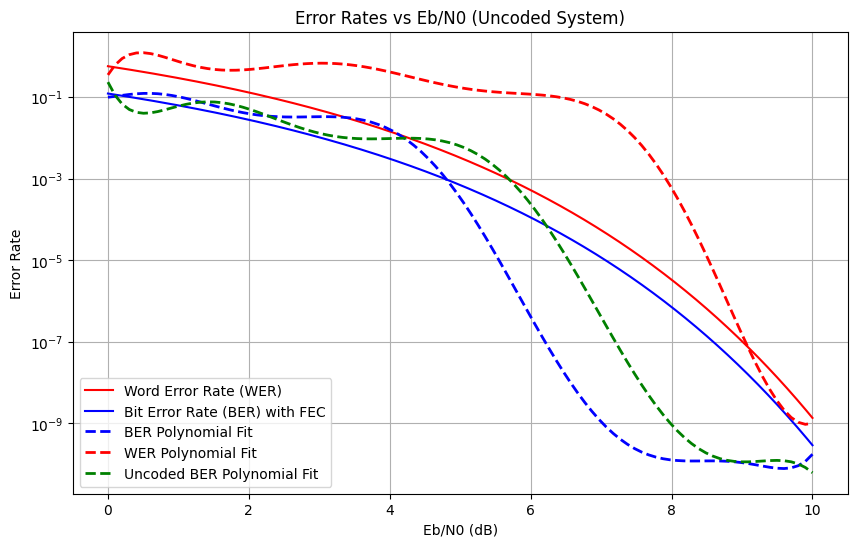

In [10]:
# Comparing results with theorical (continuous line) and with uncoded (green lines)

# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_dB, Pew, 'r-', label='Word Error Rate (WER)')
plt.semilogy(EbN0_dB, Pebf, 'b-', label='Bit Error Rate (BER) with FEC')
plt.semilogy(x_smooth, ber_curve, 'b--', linewidth=2, label='BER Polynomial Fit')
plt.semilogy(x_smooth, wer_curve, 'r--', linewidth=2, label='WER Polynomial Fit')
plt.semilogy(x_smooth, uncoded_ber_curve, 'g--', linewidth=2, label='Uncoded BER Polynomial Fit')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 (Uncoded System)')
plt.legend()

In [11]:
# Simulate error rates for coded and uncoded system, with error detection
num_trials = 100  # Number of trials for each Eb/N0 value
source_ber_detector = []  # Source bit error rate
source_wer_detector = []  # Source word error rate

for eb_n0 in EbN0:
    ber_trials = []  # Store BER for each trial
    wer_trials = []  # Store WER for each trial
    
    for _ in range(num_trials):
        source_message = np.random.randint(0, 2, k)
        
        # Coded system simulation
        encoded_message = encode_message(source_message, G)
        received_codeword = noisy_channel(encoded_message, n=n, k=k, EbfN0=eb_n0)
        if any_error(received_codeword, H):
            _ -= 1
            continue

        # Calculate bit errors
        bit_errors = np.sum(source_message != received_codeword[0, :k])
        ber_trials.append(bit_errors / k)

        # Calculate word errors
        word_errors = 1 if np.any(encoded_message != received_codeword) else 0
        wer_trials.append(word_errors)
    
    # Average the results over all trials
    source_ber_detector.append(np.mean(ber_trials))
    source_wer_detector.append(np.mean(wer_trials))

# Convert to numpy arrays and calculate average error rates
source_ber_detector = np.array(source_ber_detector)
source_wer_detector = np.array(source_wer_detector)

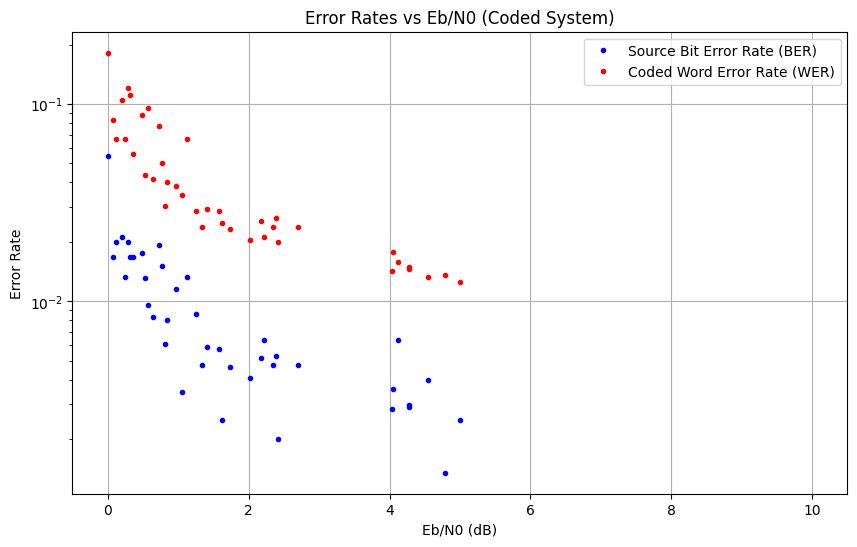

In [12]:
# Plot results
plt.figure(figsize=(10, 6))
plt.semilogy(EbN0_dB, source_ber_detector, 'b.', label='Source Bit Error Rate (BER)')
plt.semilogy(EbN0_dB, source_wer_detector, 'r.', label='Coded Word Error Rate (WER)')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 (Coded System)')
plt.legend()
plt.show()

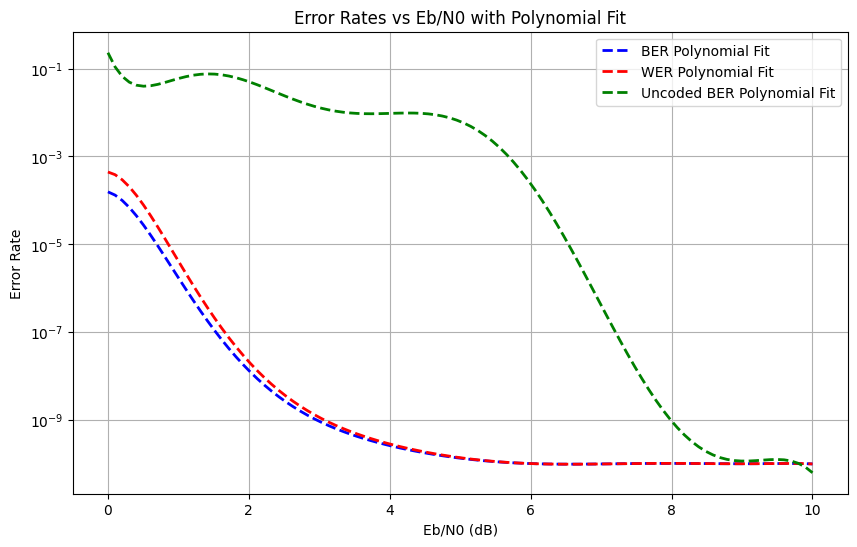

In [13]:
# Fit polynomial using least squares method
from numpy.polynomial import Polynomial

# Fit polynomials to log10 of error rates, handling zero values
# Add small epsilon to avoid log10(0)
epsilon = 1e-10
ber_poly = Polynomial.fit(EbN0_dB, np.log10(source_ber_detector + epsilon), deg=8)
wer_poly = Polynomial.fit(EbN0_dB, np.log10(source_wer_detector + epsilon), deg=8)

# Generate smooth curve points
x_smooth = np.linspace(min(EbN0_dB), max(EbN0_dB), 100)
ber_curve = 10**ber_poly(x_smooth)
wer_curve = 10**wer_poly(x_smooth)

# Plot polynomial fits with different tones
plt.figure(figsize=(10, 6))
# plt.semilogy(EbN0_dB, source_ber, 'b-', label='Source Bit Error Rate (BER)', alpha=0.3)
# plt.semilogy(EbN0_dB, source_wer, 'r-', label='Coded Word Error Rate (WER)', alpha=0.3)
# plt.semilogy(EbN0_dB, uncoded_ber, 'g-', label='Uncoded Bit Error Rate (BER)', alpha=0.3)
plt.semilogy(x_smooth, ber_curve, 'b--', linewidth=2, label='BER Polynomial Fit')
plt.semilogy(x_smooth, wer_curve, 'r--', linewidth=2, label='WER Polynomial Fit')
plt.semilogy(x_smooth, uncoded_ber_curve, 'g--', linewidth=2, label='Uncoded BER Polynomial Fit')
plt.grid(True)
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Error Rate')
plt.title('Error Rates vs Eb/N0 with Polynomial Fit')
plt.legend()
plt.show()